In [11]:
from datetime import timedelta, datetime

import pandas as pd

import sim.parameter_implementations as pimpls
import os
import sim.viz
import sim.fitting
import sim.importing
import sim.exporting
import sim.sim_tests
import sim.log_similarity
import sim.manual_modeling as mm
from sim.enums import ExecutionParameters
from sim.model_configuration import ResourceConfig, ActivityConfig, ArrivalProcessConfig, DecisionConfig
from sim.simulation import simulate, create_simulation_model

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def running_example():
    mb = mm.ModelBuilder()
    mb.set_default_arrival_config(
        ArrivalProcessConfig(datetime(2021, 10, 10, 7, 0), pimpls.ExpSampler(90), pimpls.StandardWorkweek))
    mb.add_resource('R1', ResourceConfig(3, pimpls.StandardWorkweek))
    mb.add_resource('R2', ResourceConfig(2, pimpls.StandardWorkweek))
    mb.add_resource('R3', ResourceConfig(5, pimpls.StandardWorkweek))
    mb.add_activity('A', ActivityConfig(pimpls.Fifo, pimpls.ExpSampler(10)), 'R1',
                    initial_node=True)
    mb.add_activity('B', ActivityConfig(pimpls.Fifo, pimpls.ExpSampler(30)), 'R2')
    mb.add_activity('C', ActivityConfig(pimpls.Fifo, pimpls.ExpSampler(60)), 'R2')
    mb.add_activity('D', ActivityConfig(pimpls.Fifo, pimpls.ExpSampler(45)), 'R3')
    mb.add_activity('E', ActivityConfig(pimpls.Fifo, pimpls.ExpSampler(1)), 'R1',
                    final_node=True)
    mb.add_decision('decision1', DecisionConfig(pimpls.StochasticClassifier([.75, .25])))
    mb.add_concurrency()
    mb.connect('A', 'and1_split')
    mb.connect('and1_split', ['decision1_split', 'D'])
    mb.connect('decision1_split', ['B', 'C'])
    mb.connect(['B', 'C'], 'decision1_join')
    mb.connect('decision1_join', 'and1_join')
    mb.connect('D', 'and1_join')
    mb.connect('and1_join', 'E')
    return mb.build()

def sequential_model():
    mb = mm.ModelBuilder()
    mb.set_default_arrival_config(
        ArrivalProcessConfig(datetime(2021, 10, 10, 7, 0), pimpls.ExpSampler(60), pimpls.StandardWorkweek))
    mb.add_activity('A', ActivityConfig(pimpls.Fifo, pimpls.ZeroSampler, pimpls.AlwaysInBusiness), 'R1',
                    initial_node=True)
    mb.add_activity('B', ActivityConfig(pimpls.Fifo, pimpls.ExpSampler(90), pimpls.AlwaysInBusiness), 'R2')
    mb.add_activity('C', ActivityConfig(pimpls.Fifo, pimpls.ExpSampler(60), pimpls.AlwaysInBusiness), 'R3',
                    final_node=True)
    mb.set_config('R1', ResourceConfig(100, pimpls.AlwaysInBusiness, pimpls.PeakPerformance))
    mb.set_config('R2', ResourceConfig(2, pimpls.AlwaysInBusiness, pimpls.PeakPerformance))
    mb.set_config('R3', ResourceConfig(1, pimpls.AlwaysInBusiness, pimpls.PeakPerformance))
    mb.connect('A', 'B')
    mb.connect('B', 'C')
    return mb.build()

Arrivals:
default: ArrivalProcessConfig(first_arrival=2021-10-10 07:00:00+02:00, inter_arrivals=DistSampler(expon({'scale': 90}) m), business_hours=WorkweekBusinessHours({<Weekdays.Monday: 0>: (datetime.time(9, 0), datetime.time(17, 0)), <Weekdays.Tuesday: 1>: (datetime.time(9, 0), datetime.time(17, 0)), <Weekdays.Wednesday: 2>: (datetime.time(9, 0), datetime.time(17, 0)), <Weekdays.Thursday: 3>: (datetime.time(9, 0), datetime.time(17, 0)), <Weekdays.Friday: 4>: (datetime.time(9, 0), datetime.time(17, 0))}))
Activities:
A: ActivityConfig(queueing_discipline=Fifo, processing_time_sampler=DistSampler(expon({'scale': 10}) m))
B: ActivityConfig(queueing_discipline=Fifo, processing_time_sampler=DistSampler(expon({'scale': 30}) m))
C: ActivityConfig(queueing_discipline=Fifo, processing_time_sampler=DistSampler(expon({'scale': 60}) m))
D: ActivityConfig(queueing_discipline=Fifo, processing_time_sampler=DistSampler(expon({'scale': 45}) m))
E: ActivityConfig(queueing_discipline=Fifo, processing

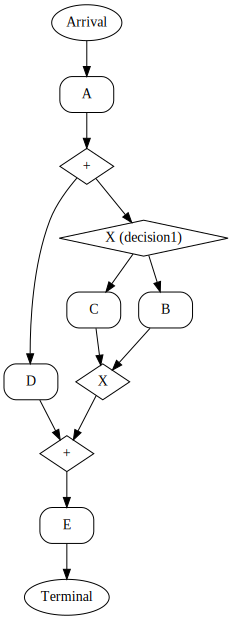

In [23]:
graph, config = running_example()
name = 'new_andor'
print(config)
gg = sim.viz.visualize_sim_graph(graph, label_decision_points=True)
sim.viz.save(gg, 'andor_model')
gg

In [14]:
ex = sim.simulation.default_execution_parameters()
ex[ExecutionParameters.CasesToGenerate] = 1000
model = create_simulation_model(graph, config, ex)
simulator = sim.simulation.simulate(model, simulation_log_filename=os.path.join('testruns', f'{name}.log'))
print(f'simulation took {simulator.duration}')
log = simulator.get_log()
sim.exporting.save_log(log, os.path.join('sim', 'testruns', f'{name}.xes'))

simulation took 0:00:03.507189


In [15]:
log

[{'attributes': {'concept:name': 'default_case_0'}, 'events': [{'concept:name': 'A', 'time:timestamp': Timestamp('2021-10-11 09:00:00+0200', tz='Mitteleuropäische Sommerzeit'), 'org:resource': 'n/a', 'lifecycle:transition': 'schedule'}, '..', {'concept:name': 'E', 'time:timestamp': Timestamp('2021-10-11 09:39:00+0200', tz='Mitteleuropäische Sommerzeit'), 'org:resource': 'R1', 'lifecycle:transition': 'complete'}]}, '....', {'attributes': {'concept:name': 'default_case_999'}, 'events': [{'concept:name': 'A', 'time:timestamp': Timestamp('2021-12-12 00:38:00+0200', tz='Mitteleuropäische Sommerzeit'), 'org:resource': 'n/a', 'lifecycle:transition': 'schedule'}, '..', {'concept:name': 'E', 'time:timestamp': Timestamp('2021-12-14 09:23:00+0200', tz='Mitteleuropäische Sommerzeit'), 'org:resource': 'R1', 'lifecycle:transition': 'complete'}]}]

In [16]:
len(log)

1000

In [17]:
l, petrinet = sim.importing.prepare_input(log)
sg, rr = sim.fitting.pre_process_input(l, petrinet)

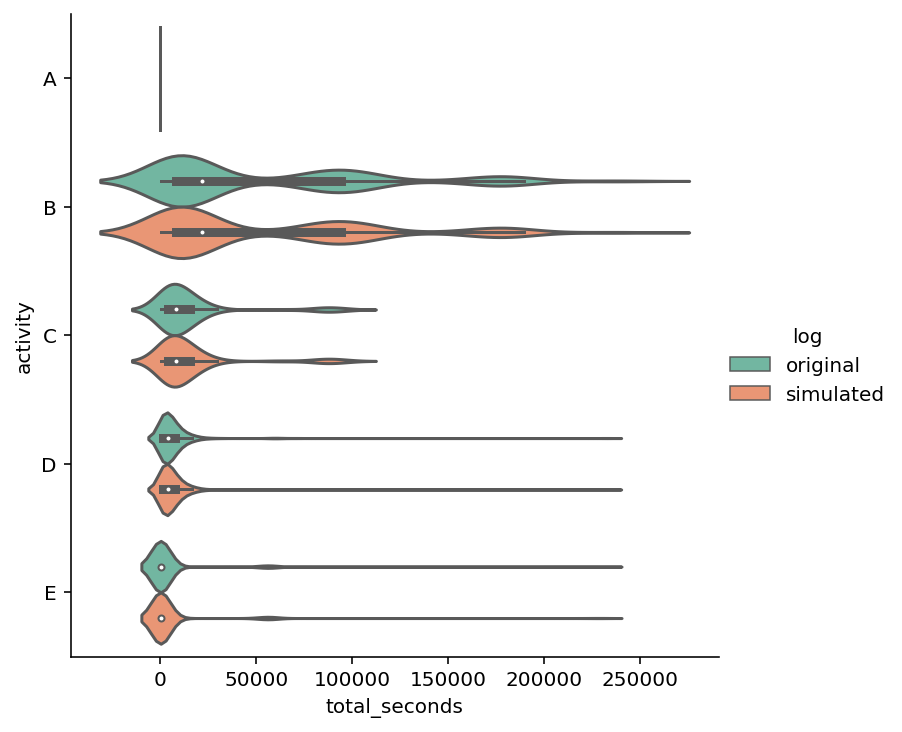

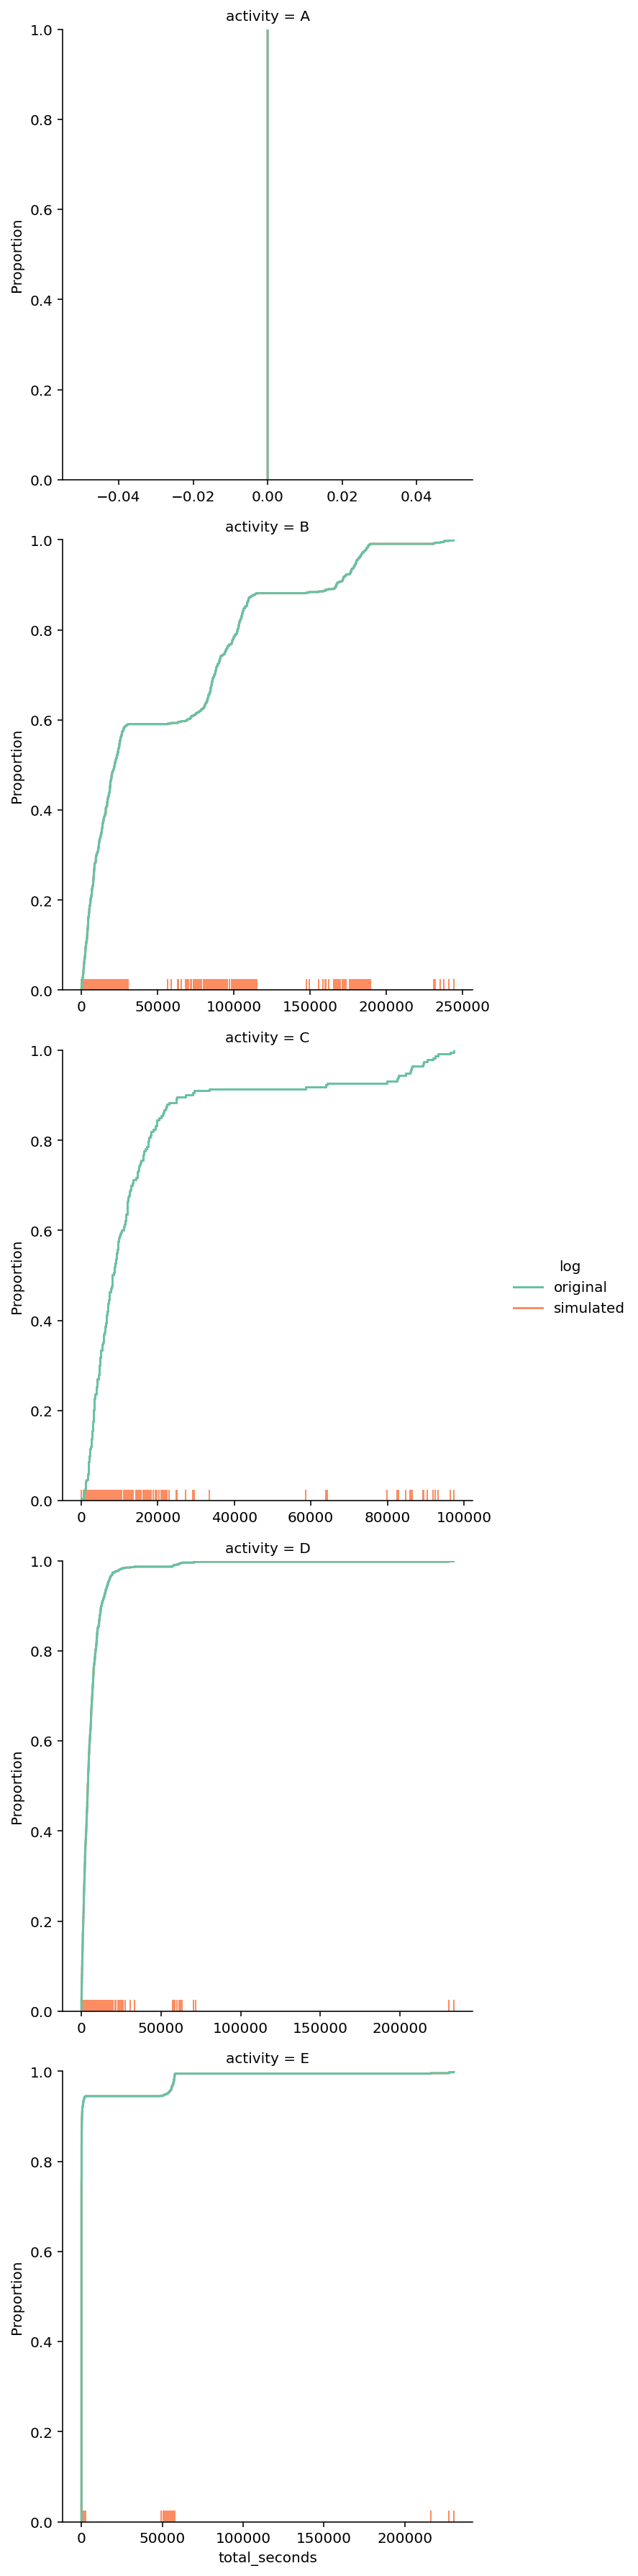

sojourn durations emd of activity A: nan
sojourn durations emd of activity B: 0.0
sojourn durations emd of activity C: 0.0
sojourn durations emd of activity D: 0.0
sojourn durations emd of activity E: 0.0


In [18]:
sim.log_similarity.visual_sojourn_durations(rr, rr)

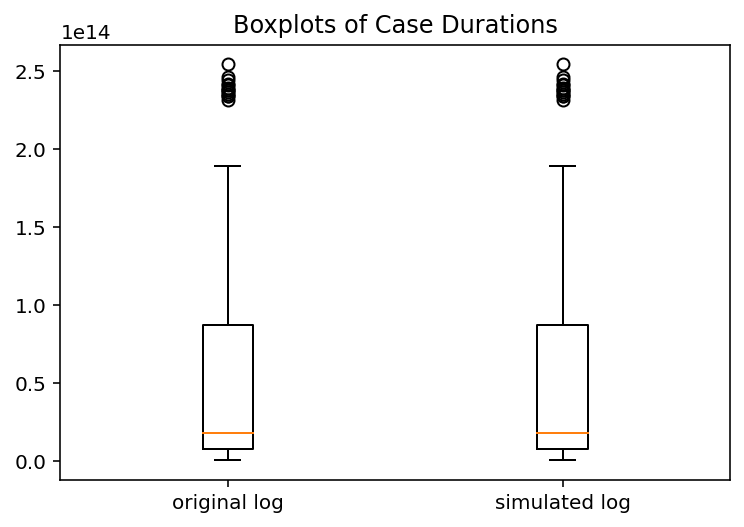

original log
count                         1000
mean        0 days 13:59:14.940000
std      0 days 16:03:58.524179612
min                0 days 00:09:00
25%                0 days 02:04:45
50%                0 days 05:00:00
75%                1 days 00:08:45
max                2 days 22:35:00
dtype: object
simulated log
count                         1000
mean        0 days 13:59:14.940000
std      0 days 16:03:58.524179612
min                0 days 00:09:00
25%                0 days 02:04:45
50%                0 days 05:00:00
75%                1 days 00:08:45
max                2 days 22:35:00
dtype: object
case_duration_emd: 0.0


In [19]:
sim.log_similarity.visual_case_duration_emd(l, l)

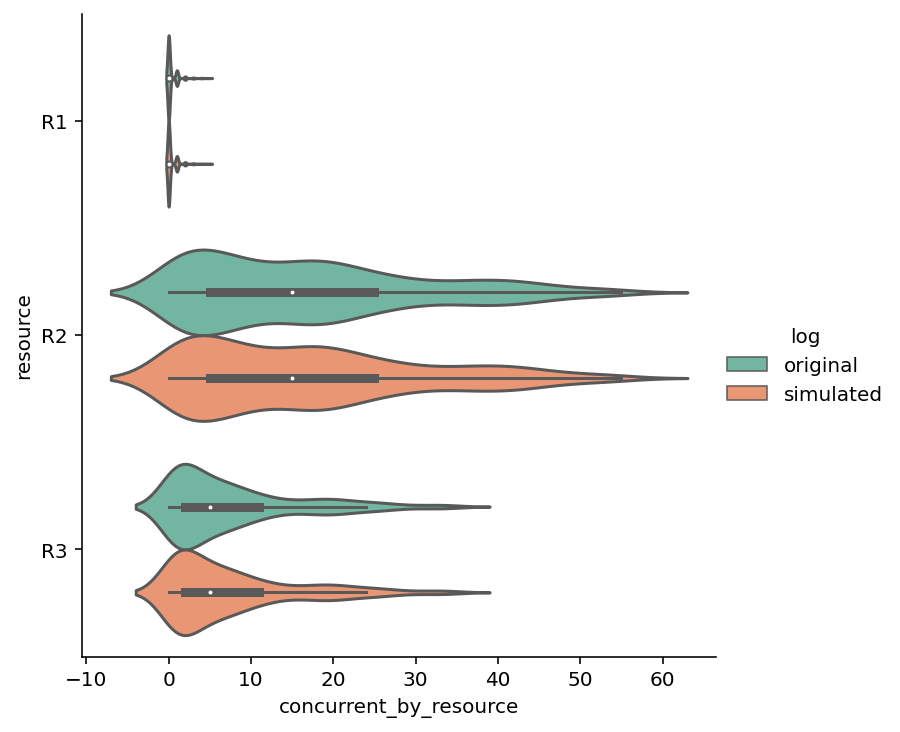

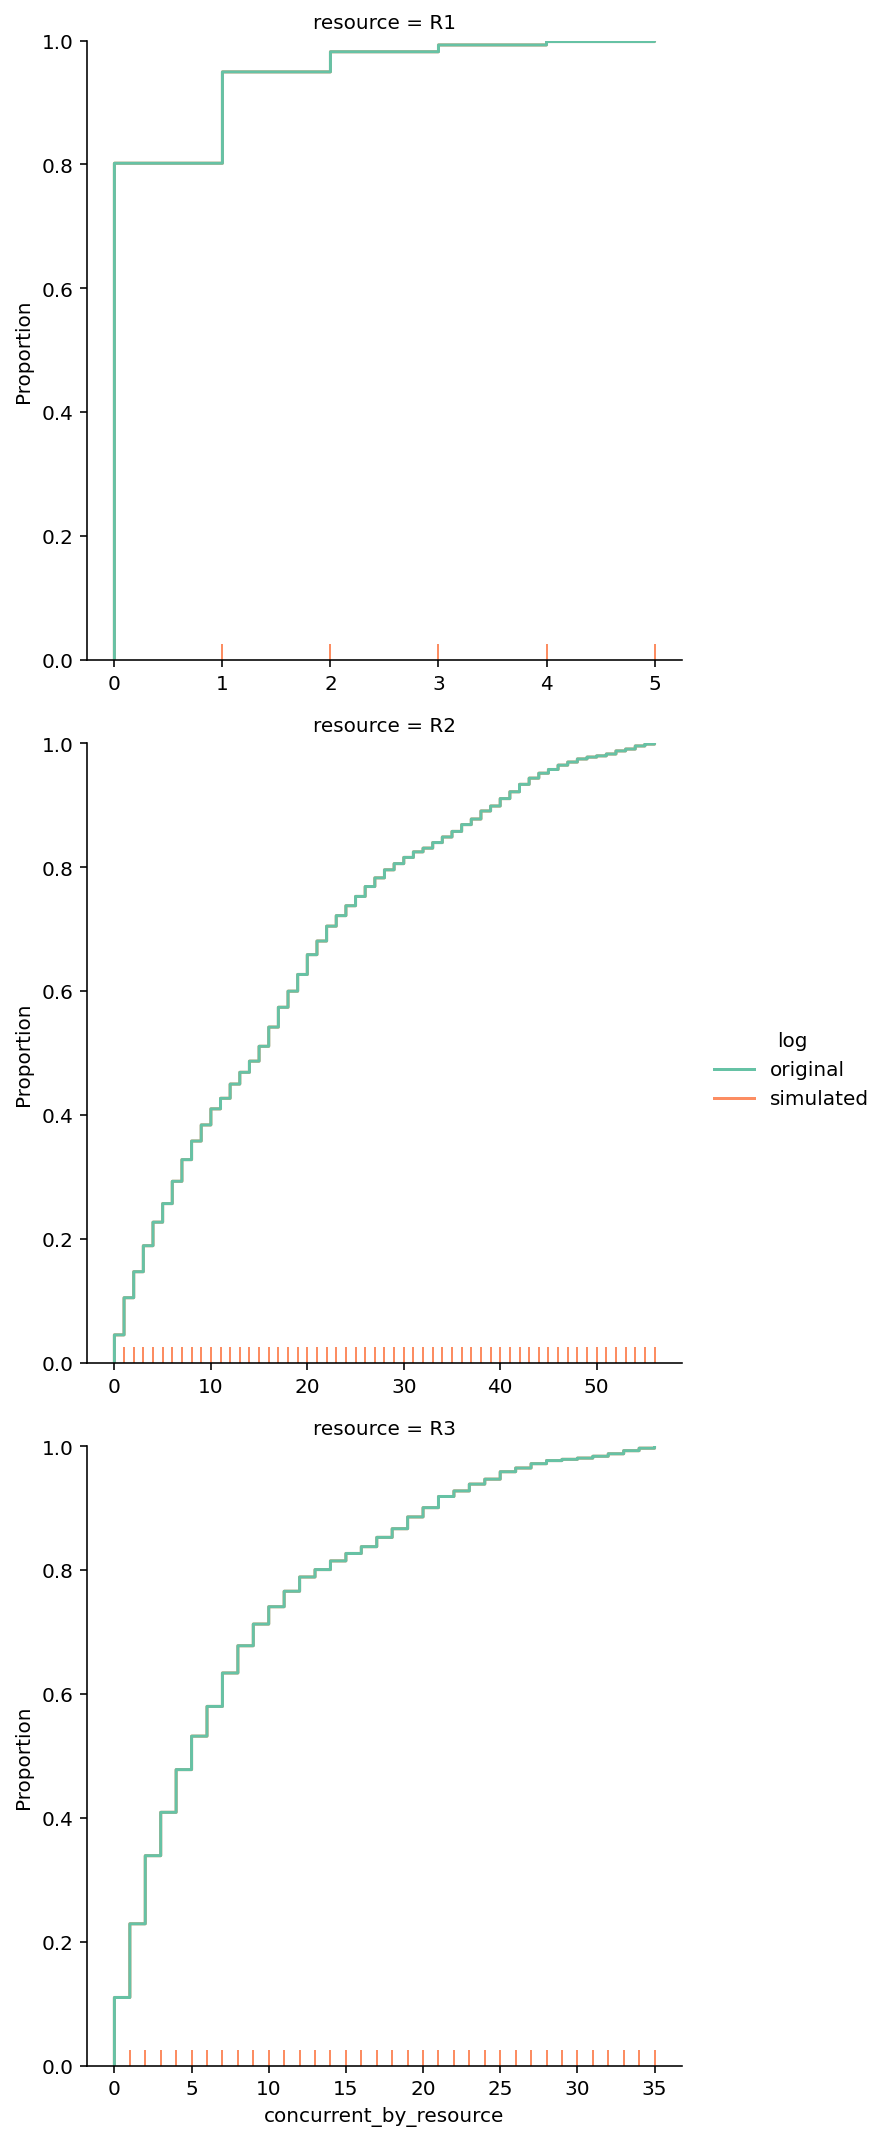

concurrent on completion emd by resource R1: 0.0
concurrent on completion emd by resource R2: 0.0
concurrent on completion emd by resource R3: 0.0


In [20]:
sim.log_similarity.visual_concurrent_on_completion(rr, rr)